In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import os
import pandas as pd
import numpy as np
import torch.nn as nn
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split, Dataset

from tqdm import tqdm
from utils.process_data import build_train_test_loaders, build_train_test_loaders_2
from utils.training import CustomMAELoss, CustomMAPELoss, test_model, get_flow_forecasting_metrics
from utils.link_loads import get_graph_attributes, df_to_graph, build_quarter_hour_data, add_missing_nodes, add_missing_nodes_2
from utils.models import STGCN
# import networkx as nx

In [3]:
folder_path = "data/"
# Get graph attributes, create dfs from csv, process Link column and ordered dfs by time
num_nodes, edge_index, node_mapping, dfs = get_graph_attributes(folder_path)

In [4]:
# Functions
def get_day_time(i):
    if i < 8: # 0500-0700
        return 'Early'
    elif i < 20: # 0700-1000
        return 'AM Peak'
    elif i < 36: # 1000-1600
        return 'Midday'
    elif i < 48: # 1600-1900
        return 'PM Peak'
    elif i < 60: # 1900-2200
        return 'Evening'
    else: # 2200-0500
        return 'Late'

class GraphForVizDataset(Dataset):
    def __init__(self, graphs, edge_index, window_size=4):
        self.graphs = graphs
        self.edge_index = edge_index
        self.window_size = window_size
        self.accesible_data_per_day = len(graphs[0]) - self.window_size
        if self.accesible_data_per_day < 0:
            print(len(graphs[0]))
            raise ValueError("Error : window_size should be lower than the number of graphs per day")
        
    def __len__(self):
        return len(self.graphs) * self.accesible_data_per_day

    def __getitem__(self, idx):
        day = idx//self.accesible_data_per_day
        qh = idx%self.accesible_data_per_day
        day_graphs = self.graphs[day]
        # print(day_graphs)

        # get current and last flows
        last_graphs = day_graphs[qh : qh + self.window_size]
        last_flows = [graph['flows'].values for graph in last_graphs]
        last_flows = torch.tensor(np.array(last_flows), dtype=torch.float32)
        last_flows = last_flows.transpose(0, 1)

        # get data to return
        idx_graph = day_graphs[qh + self.window_size]['flows']
        current_flows = torch.tensor(idx_graph.values, dtype=torch.float32)
        idx_graph = Data(x=last_flows, edge_index=self.edge_index, y=current_flows)
        year = day_graphs[qh + self.window_size]['year']
        day = day_graphs[qh + self.window_size]['day']
        qhr = day_graphs[qh + self.window_size]['qhr']

        # Temporal features: one hot encode day and day_time
        if day not in ['FRI','SAT','SUN']:
            day = 'MTWT'
        df_one_hot_encoding_day = pd.DataFrame(np.zeros((num_nodes, 4)), columns=['MTWT', 'FRI', 'SAT','SUN'])
        df_one_hot_encoding_day[day] = 1.0
        day_time = get_day_time(qh)
        df_one_hot_encoding_day_time = pd.DataFrame(np.zeros((num_nodes, 6)), columns=['Early', 'AM Peak', 'Midday','PM Peak', 'Evening', 'Late'])
        df_one_hot_encoding_day_time[day_time] = 1.0
        temporal_features = pd.concat([df_one_hot_encoding_day, df_one_hot_encoding_day_time], axis=1)
        temporal_features = temporal_features.to_numpy()
        temporal_features = torch.tensor(temporal_features, dtype=torch.float32)

        return idx_graph, year, day, qhr, temporal_features
    

def build_loader(graphs, window_size, batch_size=1, shuffle=True):
    dataset = GraphForVizDataset(graphs, edge_index, window_size)  
    return DataLoader(dataset, batch_size, shuffle)

In [5]:
# Build the Data loader
test_graphs = []
train_graphs = []
window_size = 8
# each df should have the same dimension and same nodes at the same columns
for filename, df in dfs.items():
    day = filename.split('.')[0][-3:]
    year = filename.split('.')[0][-5:-3] 
    df = add_missing_nodes_2(df, node_mapping, num_nodes) # add zeros row for missing nodes
    df_qhrs = [{"flows": df.loc[:,qhr], "year": year, "day": day, "qhr": qhr} for qhr in df.columns]

    if year == '23':
        test_graphs.append(df_qhrs)
    else:
        train_graphs.append(df_qhrs)

train_loader = build_loader(train_graphs, window_size, batch_size=1, shuffle=False)
test_loader = build_loader(test_graphs, window_size, batch_size=1, shuffle=False)

# train_loader, test_loader = build_train_test_loaders_2(graphs, window_size=8, train_split=0.8)

In [6]:
class ImprovedSTGCN(nn.Module):
    def __init__(self, node_features, hidden_dim, temporal_features_dim=10):
        super(ImprovedSTGCN, self).__init__()
        self.gcn1 = GCNConv(node_features, hidden_dim)  # GCN
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim + node_features + temporal_features_dim, hidden_dim)  # Prédiction finale
        self.fc2 = nn.Linear(hidden_dim + node_features, 1)
        # self.bn1 = nn.BatchNorm1d(hidden_dim)

    def forward(self, graph, temporal_features):
        
        x = self.gcn1(graph.x, graph.edge_index)  # GCN
        x = F.relu(x) # (num_nodes, hideen_dim)
        x = self.gcn2(x, graph.edge_index)  # GCN
        x = F.relu(x) # (num_nodes, hideen_dim)

        # Use temporal features and x as inputs of fc and use the fc layer
        x = torch.cat((x, graph.x, temporal_features), dim=-1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = torch.cat((x, graph.x), dim=-1)
        x = self.fc2(x)
        x = F.relu(x)
        return x # return the flow for each nodes (num_nodes, 1)

In [7]:
import torch
from tqdm import tqdm

# Détection du GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# Initialisation du modèle et des composants d'entraînement
model = ImprovedSTGCN(node_features=window_size, hidden_dim=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.008)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = torch.nn.L1Loss()  # MAE
MAE = CustomMAELoss()
MAPE = CustomMAPELoss()

df_results = pd.DataFrame(columns = ['year' , 'day', 'qhr', 'MAE_total', 'MAE_low_target', 'MAPE_high_target'])

num_epochs = 10

# Boucle d'entraînement
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    for graph, year, day, qhr, temporal_features in train_loader:
        temporal_features = temporal_features.flatten(start_dim=0, end_dim=1)
        optimizer.zero_grad()
        # graph.x = torch.tensor(graph.x, dtype=torch.float32)
        # temporal_features = torch.tensor(temporal_features, dtype=torch.float32)
        # print(graph.x)
        # print(temporal_features)

        output = model(graph, temporal_features)
        output = output.squeeze()
        target = graph.y  # Déplacement de la cible sur GPU
        # print(output.shape)
        # print(target.shape)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}, Train loss: {train_loss / len(train_loader)}")


    model.eval()
    test_loss = 0
    with torch.no_grad():  # Désactivation des gradients pour l'évaluation
        for graph, year, day, qhr, temporal_features in test_loader:
            temporal_features = temporal_features.squeeze()
            output = model(graph, temporal_features)
            output = output.squeeze()
            target = graph.y
            loss = criterion(output, target)
            test_loss += loss.item()

    print(f"Epoch {epoch+1}, Test loss: {test_loss / len(test_loader)}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Train loss: 53.17612813903356


 10%|█         | 1/10 [00:21<03:12, 21.38s/it]

Epoch 1, Test loss: 49.86389841752894
Epoch 2, Train loss: 27.06698235953815


 20%|██        | 2/10 [00:41<02:46, 20.85s/it]

Epoch 2, Test loss: 33.22953806764939


 20%|██        | 2/10 [00:54<03:39, 27.38s/it]


KeyboardInterrupt: 

In [8]:
model.eval()
test_loss = 0
with torch.no_grad():  # Désactivation des gradients pour l'évaluation
    loss_mae = 0
    MAPE_high_target = 0
    MAE_low_target = 0
    for graph, year, day, qhr, temporal_features in test_loader:
        # Output/Target
        temporal_features = temporal_features.squeeze()            
        output = model(graph, temporal_features)
        target = graph.y

        # Calculate losses
        MAE_total = MAE(output, target)
        loss_mae += MAE_total
        MAPE_high_target_ , MAE_low_target_ = get_flow_forecasting_metrics(output, target)
        MAPE_high_target += MAPE_high_target_
        MAE_low_target += MAE_low_target_

        df_results.loc[len(df_results)] = {'year': year, 'day': day, 'qhr': qhr, 'MAE_total': MAE_total, 'MAE_low_target': MAE_low_target_, 'MAPE_high_target': MAPE_high_target_}


    mae_total = loss_mae / len(test_loader)
    mae_low_target = MAE_low_target/ len(test_loader)
    mape_high_target = MAPE_high_target / len(test_loader)

# Viz of network predictions/errors

In [9]:
# qh_performance  = {quarter_hour: 0 for quarter_hour in quarter_hours}
# days_performance = {day: 0 for day in days}
df_results = pd.DataFrame(columns = ['year' , 'day', 'qhr', 'MAE_total', 'MAE_low_target', 'MAPE_high_target'])

In [11]:
model_loaded = ImprovedSTGCN(node_features=8, hidden_dim=32)
model_loaded.load_state_dict(torch.load("models/STGCN_ws=8.pth",  map_location=torch.device('cpu')))

C:\Users\tengo\AppData\Local\Temp\ipykernel_23508\1207648331.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_loaded.load_state_dict(torch.load("models/STGCN_ws=8.p

<All keys matched successfully>

In [12]:
model_loaded.eval()
MAE = CustomMAELoss()
MAPE = CustomMAPELoss()

df_results = pd.DataFrame(columns = ['year' , 'day', 'qhr', 'MAE_total', 'MAE_low_target', 'MAPE_high_target'])

with torch.no_grad():  # Désactivation des gradients pour l'évaluation
    loss_mae = 0
    MAPE_high_target = 0
    MAE_low_target = 0
    for graph, year, day, qhr, temporal_features in test_loader:

        # Output/Target
        temporal_features = temporal_features.flatten(start_dim=0, end_dim=1)
        graph = graph
        output = model_loaded(graph, temporal_features)
        output = output.squeeze()
        target = graph.y

        # loss = criterion(output, target)
        # test_loss += loss.item()

        # Calculate losses
        # loss_mae = 0
        # MAPE_high_target = 0
        # MAE_low_target = 0

        MAE_total = float(MAE(output, target))
        loss_mae += MAE_total
        MAPE_high_target_ , MAE_low_target_ = get_flow_forecasting_metrics(output, target)
        MAPE_high_target += MAPE_high_target_
        MAE_low_target += MAE_low_target_

        for i in range(len(year)):
            df_results.loc[len(df_results)] = {'year': year[i], 'day': day[i], 'qhr': qhr[i], 'MAE_total': MAE_total, 'MAE_low_target': MAE_low_target_, 'MAPE_high_target': MAPE_high_target_}


    mae_total = loss_mae / len(test_loader)
    mae_low_target = MAE_low_target/ len(test_loader)
    mape_high_target = MAPE_high_target / len(test_loader)


# print(f"Test loss: {test_loss / len(test_loader)}")

print(f"MAE: {loss_mae / len(test_loader)}")
print(f"MAE_low_target: {MAE_low_target / len(test_loader)}")
print(f"MAPE_high_target: {MAPE_high_target / len(test_loader)}")

MAE: 11.078980917790357
MAE_low_target: 4.307728347357582
MAPE_high_target: 0.0309657221824369


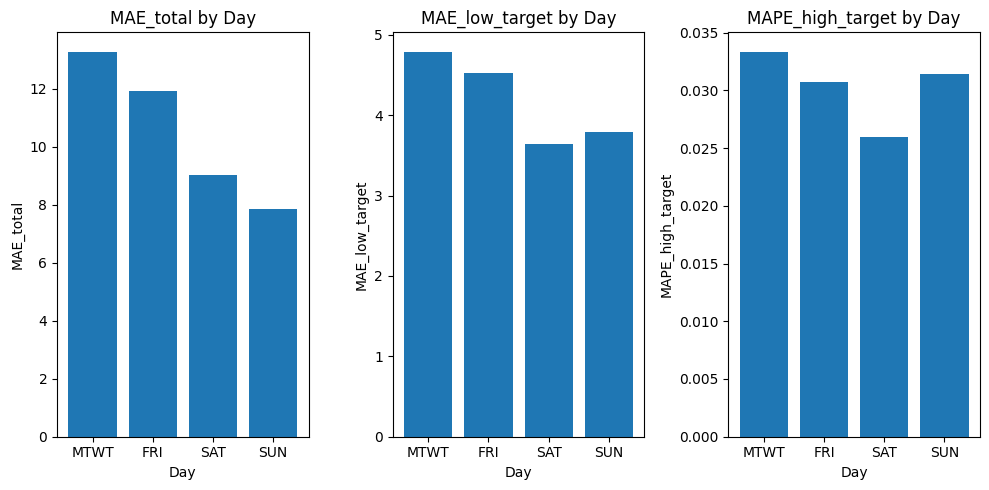

In [13]:
# prompt: Pareil que précédemment mais je veux trois graphes différent un pour chaque métriques, les jours doivent etre dans cette ordre : MTWT, FRI, SAT, SUN

import matplotlib.pyplot as plt

# Assuming df_results is already created and populated as in your code
# and contains columns 'day', 'MAE_total', 'MAE_low_target', 'MAPE_high_target'

# Define the desired day order
day_order = ['MTWT', 'FRI', 'SAT', 'SUN']

# Group data by 'day' and calculate the mean of the metrics, respecting the day order
grouped_results = df_results.groupby('day')[['MAE_total', 'MAE_low_target', 'MAPE_high_target']].mean().reindex(day_order)

# Create three separate subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Plot MAE_total
axes[0].bar(grouped_results.index, grouped_results['MAE_total'])
axes[0].set_xlabel('Day')
axes[0].set_ylabel('MAE_total')
axes[0].set_title('MAE_total by Day')


# Plot MAE_low_target
axes[1].bar(grouped_results.index, grouped_results['MAE_low_target'])
axes[1].set_xlabel('Day')
axes[1].set_ylabel('MAE_low_target')
axes[1].set_title('MAE_low_target by Day')

# Plot MAPE_high_target
axes[2].bar(grouped_results.index, grouped_results['MAPE_high_target'])
axes[2].set_xlabel('Day')
axes[2].set_ylabel('MAPE_high_target')
axes[2].set_title('MAPE_high_target by Day')

plt.tight_layout()
plt.show()


In [14]:
quarter_hours = list(dfs['Link_Loads_NBT16MTT.csv'].iloc[:, 17+window_size : 93].columns)
days = ['MON','TWT','FRI','SAT','SUN']

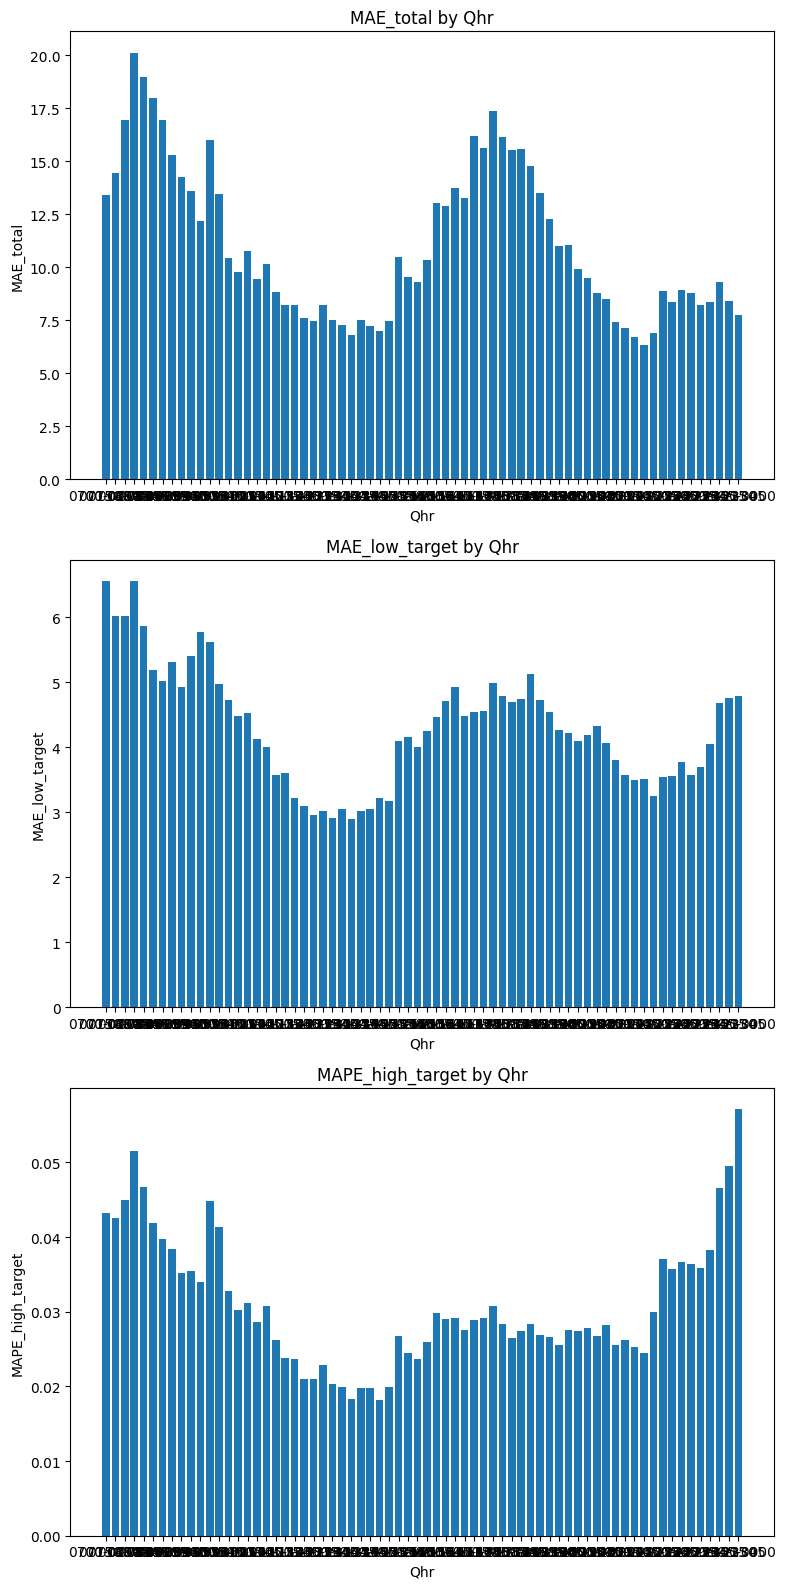

In [15]:
import matplotlib.pyplot as plt

# Define the desired day order
day_order = ['MTWT', 'FRI', 'SAT', 'SUN']

# Group data by 'day' and calculate the mean of the metrics, respecting the day order
grouped_results = df_results.groupby('qhr')[['MAE_total', 'MAE_low_target', 'MAPE_high_target']].mean().reindex(quarter_hours)

# Create three separate subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 16))

# Plot MAE_total
axes[0].bar(grouped_results.index, grouped_results['MAE_total'])
axes[0].set_xlabel('Qhr')
axes[0].set_ylabel('MAE_total')
axes[0].set_title('MAE_total by Qhr')


# Plot MAE_low_target
axes[1].bar(grouped_results.index, grouped_results['MAE_low_target'])
axes[1].set_xlabel('Qhr')
axes[1].set_ylabel('MAE_low_target')
axes[1].set_title('MAE_low_target by Qhr')

# Plot MAPE_high_target
axes[2].bar(grouped_results.index, grouped_results['MAPE_high_target'])
axes[2].set_xlabel('Qhr')
axes[2].set_ylabel('MAPE_high_target')
axes[2].set_title('MAPE_high_target by Qhr')

plt.tight_layout()
plt.show()

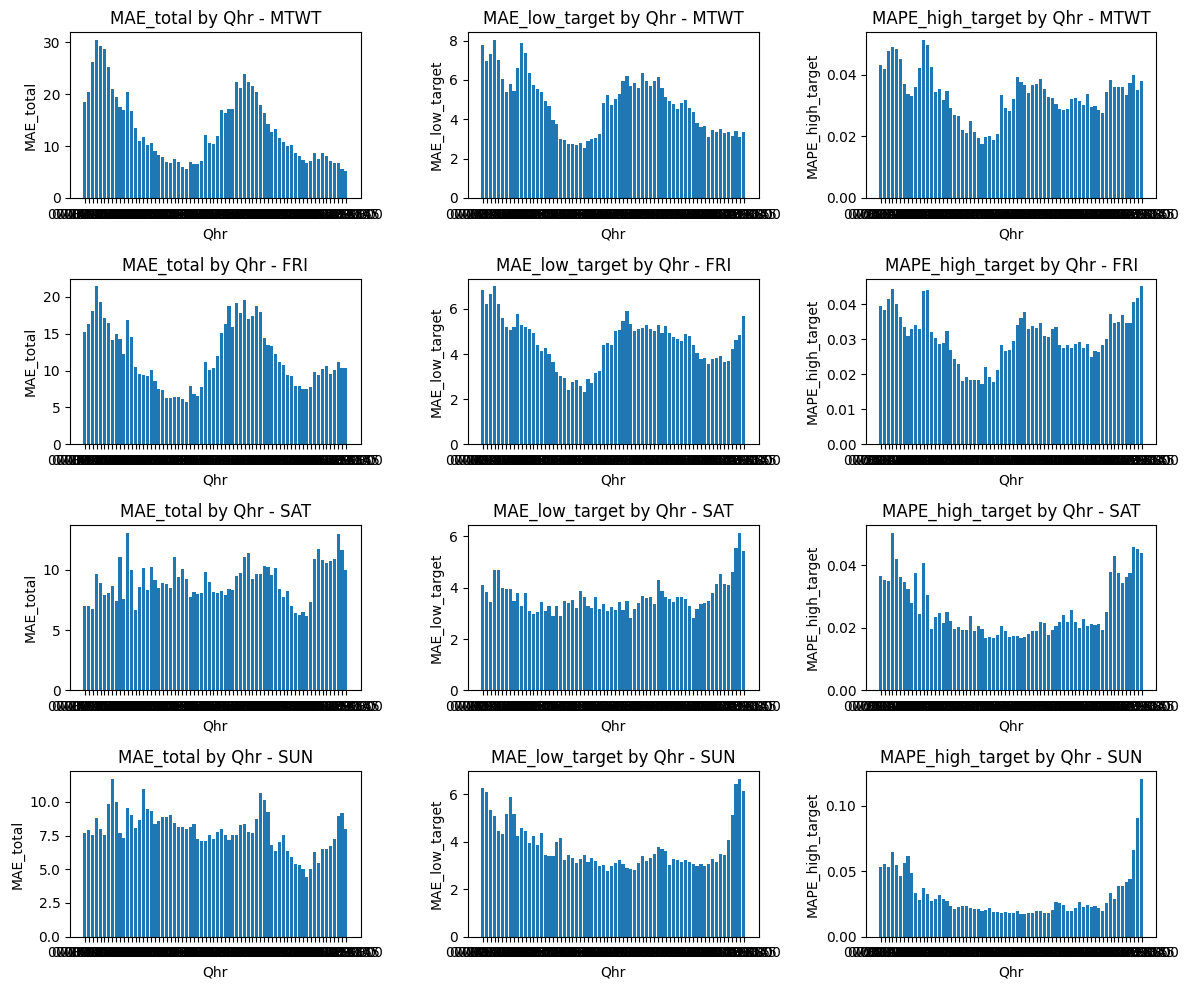

In [30]:
import matplotlib.pyplot as plt

# Ordre des jours
day_order = ['MTWT', 'FRI', 'SAT', 'SUN']

# Groupement des données
grouped_results = df_results.groupby(['day', 'qhr'])[['MAE_total', 'MAE_low_target', 'MAPE_high_target']].mean()

# Création des sous-graphiques
fig, axes = plt.subplots(4, 3, figsize=(12, 10))

quarter_hours = grouped_results.index.get_level_values('qhr').unique()  # Liste des quarts d'heures

for i, day in enumerate(day_order):
    
    # Filtrage des données pour le jour en cours
    day_data = grouped_results.loc[grouped_results.index.get_level_values('day') == day]

    # Plot MAE_total
    axes[i, 0].bar(day_data.index.get_level_values('qhr'), day_data['MAE_total'])
    axes[i, 0].set_xlabel('Qhr')
    axes[i, 0].set_ylabel('MAE_total')
    axes[i, 0].set_title(f'MAE_total by Qhr - {day}')

    # Plot MAE_low_target
    axes[i, 1].bar(day_data.index.get_level_values('qhr'), day_data['MAE_low_target'])
    axes[i, 1].set_xlabel('Qhr')
    axes[i, 1].set_ylabel('MAE_low_target')
    axes[i, 1].set_title(f'MAE_low_target by Qhr - {day}')

    # Plot MAPE_high_target
    axes[i, 2].bar(day_data.index.get_level_values('qhr'), day_data['MAPE_high_target'])
    axes[i, 2].set_xlabel('Qhr')
    axes[i, 2].set_ylabel('MAPE_high_target')
    axes[i, 2].set_title(f'MAPE_high_target by Qhr - {day}')

plt.tight_layout()
plt.show()


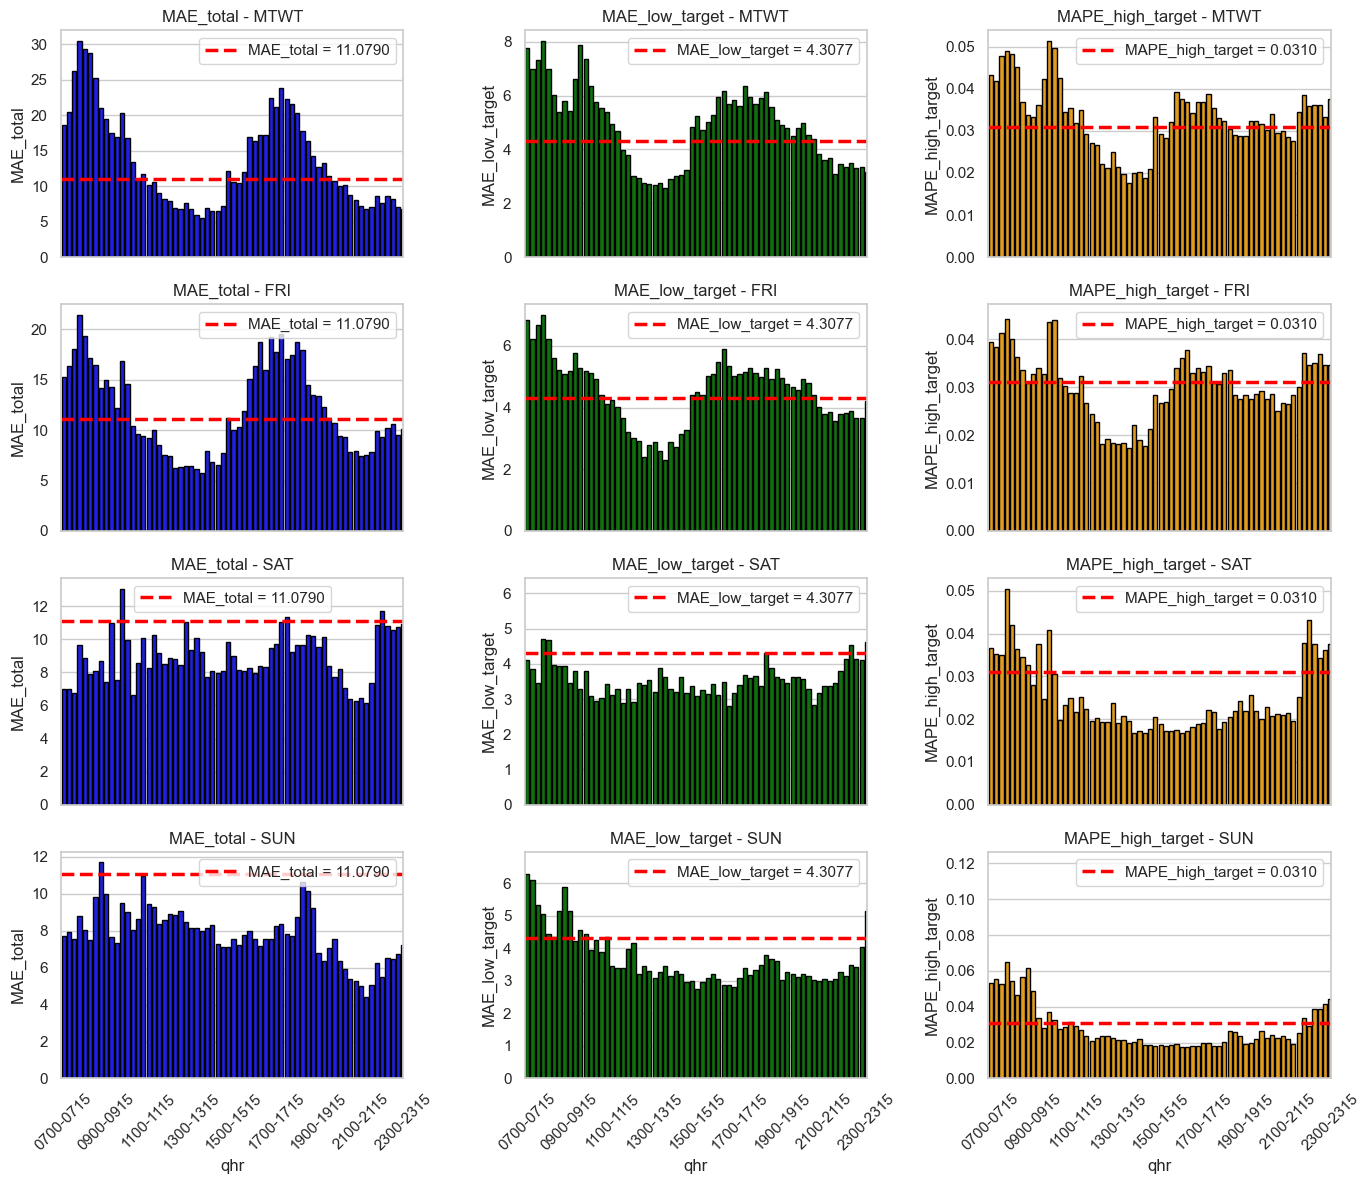

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Appliquer un thème Seaborn
sns.set_theme(style="whitegrid")

# Ordre des jours
day_order = ['MTWT', 'FRI', 'SAT', 'SUN']

# Groupement des données
grouped_results = df_results.groupby(['day', 'qhr'])[['MAE_total', 'MAE_low_target', 'MAPE_high_target']].mean().reset_index()

# Définition des valeurs d'erreurs globales
errors = {
    "MAE_total": 11.078980990718392,
    "MAE_low_target": 4.307728366992053,
    "MAPE_high_target": 0.030965722061912802
}

# Création des sous-graphiques
fig, axes = plt.subplots(4, 3, figsize=(14, 12), sharex=True)

for i, day in enumerate(day_order):
    day_data = grouped_results[grouped_results["day"] == day]

    for j, metric in enumerate(["MAE_total", "MAE_low_target", "MAPE_high_target"]):
        sns.barplot(x="qhr", y=metric, data=day_data, ax=axes[i, j], color=["blue", "green", "orange"][j], edgecolor="black")
        axes[i, j].axhline(y=errors[metric], color="red", linestyle="--", linewidth=2.5, label=f"{metric} = {errors[metric]:.4f}")
        axes[i, j].set_title(f"{metric} - {day}")
        axes[i, j].set_ylabel(metric)
        axes[i, j].legend()

        # Sélectionner les indices pour les ticks (tous les 8 éléments)
        ticks = range(0, len(day_data["qhr"]), 8)
        axes[i, j].set_xticks(ticks)
        axes[i, j].set_xticklabels(day_data["qhr"].iloc[ticks], rotation=45)

# Ajustement de la mise en page
plt.tight_layout()
plt.show()


In [9]:
class ImprovedSTGCN(nn.Module):
    def __init__(self, node_features, hidden_dim, temporal_features_dim=10):
        super(ImprovedSTGCN, self).__init__()
        self.gcn1 = GCNConv(node_features, hidden_dim)  # GCN
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim + node_features + temporal_features_dim, hidden_dim)  # Prédiction finale
        self.fc2 = nn.Linear(hidden_dim + node_features, 1)
        # self.bn1 = nn.BatchNorm1d(hidden_dim)

    def forward(self, graph, temporal_features):
        
        x = self.gcn1(graph.x, graph.edge_index)  # GCN
        x = F.relu(x) # (num_nodes, hideen_dim)
        x = self.gcn2(x, graph.edge_index)  # GCN
        x = F.relu(x) # (num_nodes, hideen_dim)

        # Use temporal features and x as inputs of fc and use the fc layer
        x = torch.cat((x, graph.x, temporal_features), dim=-1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = torch.cat((x, graph.x), dim=-1)
        x = self.fc2(x)
        x = F.relu(x)
        return x # return the flow for each nodes (num_nodes, 1)

In [10]:
model_loaded = ImprovedSTGCN(node_features=8, hidden_dim=32)
model_loaded.load_state_dict(torch.load("models/STGCN_ws=8.pth",  map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
day_order = ['MTWT', 'FRI', 'SAT', 'SUN']
week_passenger = {day: [] for day in day_order}
week_passenger_prediction = {day: [] for day in day_order}
for graph, year, day, qhr, temporal_features in test_loader:
    week_passenger[day[0]].append(graph.y.sum().item())
    temporal_features = temporal_features.squeeze()
    pred = model_loaded(graph, temporal_features)
    week_passenger_prediction[day[0]].append(pred.sum().item())
week_passenger['MON'] = week_passenger['MTWT'][68:]
week_passenger['TWT'] = week_passenger['MTWT'][:68]
week_passenger_prediction['MON'] = week_passenger_prediction['MTWT'][68:]
week_passenger_prediction['TWT'] = week_passenger_prediction['MTWT'][:68]

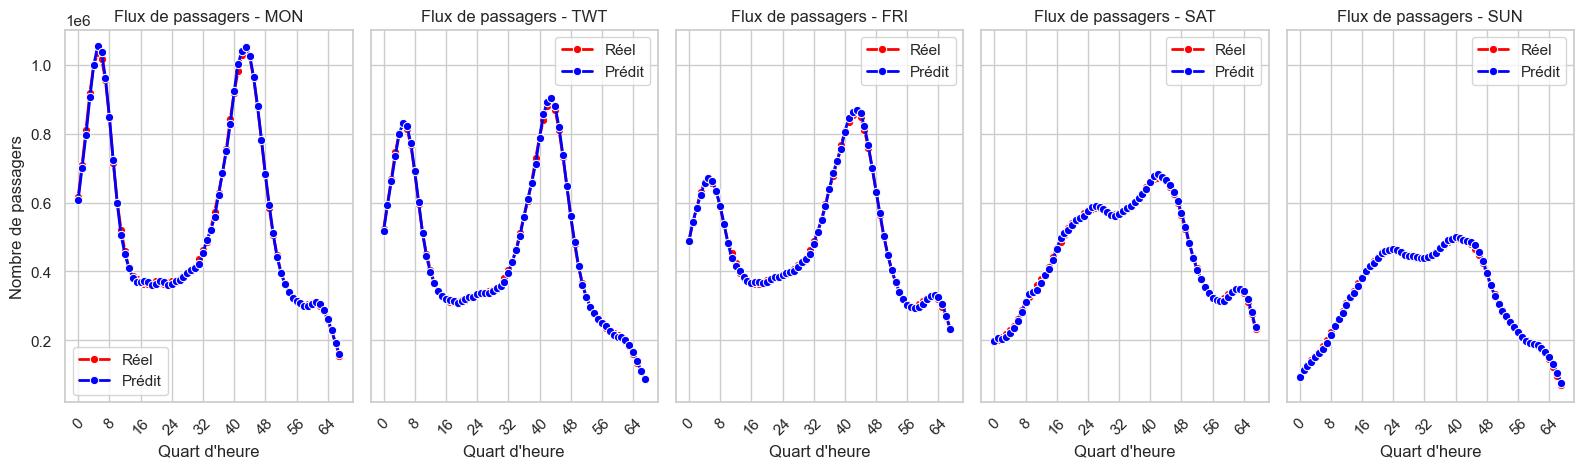

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Appliquer un thème Seaborn
sns.set_theme(style="whitegrid")

# Création des sous-graphiques (1 par jour)
fig, axes = plt.subplots(1, 5, figsize=(16, 5), sharey=True)

for i, day in enumerate(['MON', 'TWT', 'FRI', 'SAT', 'SUN']):
    
    qhr = range(len(week_passenger[day]))  # Index des quarts d'heures
    flux = week_passenger[day]  # Liste des flux pour le jour donné
    pred_flux = week_passenger_prediction[day]  # Prédictions

    # Tracé de la courbe réelle
    sns.lineplot(x=qhr, y=flux, ax=axes[i], color="red", marker="o", linewidth=2, label="Réel")
    
    # Tracé de la courbe prédite
    sns.lineplot(x=qhr, y=pred_flux, ax=axes[i], color="blue", marker="o", linewidth=2, label="Prédit")

    axes[i].set_title(f"Flux de passagers - {day}")
    axes[i].set_xlabel("Quart d'heure")
    axes[i].set_ylabel("Nombre de passagers")
    
    # Ajout d'une légende pour distinguer les courbes
    axes[i].legend()

    # Sélectionner les indices pour afficher un tick X tous les 8 quarts d’heure
    ticks = range(0, len(qhr), 8)
    axes[i].set_xticks(ticks)
    axes[i].set_xticklabels(ticks, rotation=45)

# Ajustement de la mise en page
plt.tight_layout()
plt.show()


# Viz of Northern Line's flow

In [9]:
for filename, df in dfs.items():
    day = filename.split('.')[0][-3:]
    year = filename.split('.')[0][-5:-3] 
    if year == '23':
        df_line_info = df[(df['Line'] =='Northern') & (df['Dir'] =='NB')][['Link', 'From Station', 'To Station', 'Total']][:10]
        df_to_add = df[(df['Line'] =='Northern') & (df['Dir'] =='NB')][['Link', 'From Station', 'To Station', 'Total']][11:12]
        df_line_info = pd.concat([df_line_info, df_to_add])
        df_to_add = df[(df['Line'] =='Northern') & (df['Dir'] =='NB')][['Link', 'From Station', 'To Station', 'Total']][15:24]
        df_line_info = pd.concat([df_line_info, df_to_add])
        df_to_add = df[(df['Line'] =='Northern') & (df['Dir'] =='NB')][['Link', 'From Station', 'To Station', 'Total']][25:26]
        df_line_info = pd.concat([df_line_info, df_to_add])
        df_to_add = df[(df['Line'] =='Northern') & (df['Dir'] =='NB')][['Link', 'From Station', 'To Station', 'Total']][48:57]
        df_line_info = pd.concat([df_line_info, df_to_add]) 
        break
line_links = list(df_line_info['Link'])
line_nodes = [node_mapping[link] for link in line_links]

In [11]:
train_loader = build_loader(train_graphs, window_size, batch_size=1, shuffle=False)
test_loader = build_loader(test_graphs, window_size, batch_size=1, shuffle=False)

In [48]:
model_loaded = ImprovedSTGCN(node_features=8, hidden_dim=32)
model_loaded.load_state_dict(torch.load("models/STGCN_ws=8.pth",  map_location=torch.device('cpu')))

<All keys matched successfully>

In [49]:
model_loaded.eval()

day_order = ['MTWT', 'FRI', 'SAT', 'SUN']
week_flow_23 = {day: [] for day in day_order}
week_flow_23_prediction = {day: [] for day in day_order}    

with torch.no_grad():  # Désactivation des gradients pour l'évaluation
    for graph, year, day, qhr, temporal_features in test_loader:
        
        # Output/Target
        temporal_features = temporal_features.squeeze()
        output = model_loaded(graph, temporal_features)
        output = output.squeeze()
        target = graph.y.squeeze()

        # Get the output/target from northern line nodes
        line_output_flow = [output[node].item() for node in line_nodes]
        line_target_flow = [target[node].item() for node in line_nodes]

        # Save the output/target
        week_flow_23[day[0]].append(line_output_flow)
        week_flow_23_prediction[day[0]].append(line_target_flow)

week_flow_23['MON'] = week_flow_23['MTWT'][68:]
week_flow_23['TWT'] = week_flow_23['MTWT'][:68]
week_flow_23_prediction['MON'] = week_flow_23_prediction['MTWT'][68:]
week_flow_23_prediction['TWT'] = week_flow_23_prediction['MTWT'][:68]

In [ ]:
quarter_hours = list(dfs['Link_Loads_NBT16MTT.csv'].iloc[:, 17+window_size : 93].columns)
days = ['MON','TWT','FRI','SAT','SUN']

In [50]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import pandas as pd

# Exemple de données : week_flow_23 et week_flow_23_prediction doivent être définis avant exécution.
# Chaque dictionnaire a une structure : {'MON': [[...], [...], ...], 'TWT': [[...], [...], ...], ...}

stations = [f"Station {i+1}" for i in range(30)]
jours = ['MON', 'TWT', 'FRI', 'SAT', 'SUN']
quarter_hours = list(dfs['Link_Loads_NBT16MTT.csv'].iloc[:, 17+window_size : 93].columns)

# Création de l'application Dash
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Comparaison des flux réels et prédits - 2023"),
    
    # Sélecteur du jour
    dcc.Dropdown(id="jour-selector", 
                 options=[{"label": j, "value": j} for j in jours], 
                 value="MON"),
    
    # Slider pour naviguer dans le temps
    dcc.Slider(id="time-slider", 
               min=0, max=67, step=1, value=0,
               marks={i: quarter_hours[i] for i in range(0, 68, 10)},
               tooltip={"placement": "bottom", "always_visible": True}),
    
    # Graphique
    dcc.Graph(id="flux-graph")
])

# Callback pour mettre à jour le graphique en fonction des choix utilisateur
@app.callback(
    Output("flux-graph", "figure"),
    [Input("jour-selector", "value"), Input("time-slider", "value")]
)
def update_graph(selected_jour, selected_time):
    # Récupérer les flux réels et prédits
    flux_reel = week_flow_23[selected_jour][selected_time]
    flux_pred = week_flow_23_prediction[selected_jour][selected_time]

    # Création du graphique
    fig = go.Figure()

    # Ajout des données réelles
    fig.add_trace(go.Scatter(x=stations, y=flux_reel, 
                             mode="lines+markers", 
                             name="Flux Réel",
                             line=dict(color="blue")))

    # Ajout des données prédites
    fig.add_trace(go.Scatter(x=stations, y=flux_pred, 
                             mode="lines+markers", 
                             name="Flux Prédit",
                             line=dict(color="red", dash="dash")))

    # Mise en forme du graphique
    fig.update_layout(
        title=f"Flux de passagers - {selected_jour}, {quarter_hours[selected_time]}",
        xaxis_title="Stations",
        yaxis_title="Nombre de passagers",
        legend_title="Données",
    )

    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


In [36]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import pandas as pd

# Exemple de données : week_flow_23 et week_flow_23_prediction doivent être définis avant exécution.
# Chaque dictionnaire a une structure : {'MON': [[...], [...], ...], 'TWT': [[...], [...], ...], ...}

stations = [f"Station {i+1}" for i in range(30)]
jours = ['MON', 'TWT', 'FRI', 'SAT', 'SUN']
quarter_hours = list(dfs['Link_Loads_NBT16MTT.csv'].iloc[:, 17+window_size : 93].columns)

# Création de l'application Dash
app = dash.Dash(__name__)

# Valeurs maximales et minimales des flux sur l'ensemble des données (pour fixer l'échelle des ordonnées)
# Ceci peut être ajusté en fonction des valeurs spécifiques de ton dataset.
min_flux = 0
max_flux = max([max(max(week_flow_23[jour])) for jour in jours])*1.2

app.layout = html.Div([
    html.H1("Comparaison des flux réels et prédits - 2023"),
    
    # Sélecteur du jour
    dcc.Dropdown(id="jour-selector", 
                 options=[{"label": j, "value": j} for j in jours], 
                 value="MON"),
    
    # Slider pour naviguer dans le temps
    dcc.Slider(id="time-slider", 
               min=0, max=67, step=1, value=0,
               marks={i: quarter_hours[i] for i in range(0, 68, 10)},
               tooltip={"placement": "bottom", "always_visible": True}),
    
    # Graphique
    dcc.Graph(id="flux-graph")
])

# Callback pour mettre à jour le graphique en fonction des choix utilisateur
@app.callback(
    Output("flux-graph", "figure"),
    [Input("jour-selector", "value"), Input("time-slider", "value")]
)
def update_graph(selected_jour, selected_time):
    # Récupérer les flux réels et prédits
    flux_reel = week_flow_23[selected_jour][selected_time]
    flux_pred = week_flow_23_prediction[selected_jour][selected_time]

    # Création du graphique
    fig = go.Figure()

    # Ajout des données réelles
    fig.add_trace(go.Scatter(x=stations, y=flux_reel, 
                             mode="lines+markers", 
                             name="Flux Réel",
                             line=dict(color="blue")))

    # Ajout des données prédites
    fig.add_trace(go.Scatter(x=stations, y=flux_pred, 
                             mode="lines+markers", 
                             name="Flux Prédit",
                             line=dict(color="red", dash="dash")))

    # Mise en forme du graphique
    fig.update_layout(
        title=f"Flux de passagers - {selected_jour}, {quarter_hours[selected_time]}",
        xaxis_title="Stations",
        yaxis_title="Nombre de passagers",
        legend_title="Données",
        yaxis=dict(range=[min_flux, max_flux]),  # Fixation de l'échelle des ordonnées
    )

    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


With Linear model

In [41]:
def LinearModel(graph, _):
    pred = []
    for station_flow in graph.x:
        station_flow = station_flow[-4:]
        # Predict the output for each nodes
        num_features = station_flow.shape[0]
        x = np.arange(num_features)
        x_mean = x.mean()
        y_mean = station_flow.mean().numpy()
        a = np.sum((x - x_mean) * (station_flow.numpy() - y_mean)) / np.sum((x - x_mean) ** 2)
        b = y_mean - a * x_mean
        pred.append(a * num_features + b)

    pred = torch.tensor(pred)
    return pred

In [44]:
model = LinearModel

day_order = ['MTWT', 'FRI', 'SAT', 'SUN']
week_flow_23 = {day: [] for day in day_order}
week_flow_23_prediction = {day: [] for day in day_order}    

with torch.no_grad():  # Désactivation des gradients pour l'évaluation
    for graph, year, day, qhr, temporal_features in test_loader:
        print(day)
        
        # Output/Target
        temporal_features = temporal_features.squeeze()
        output = model(graph, temporal_features)
        output = output.squeeze()
        target = graph.y.squeeze()

        # Get the output/target from northern line nodes
        line_output_flow = [output[node].item() for node in line_nodes]
        line_target_flow = [target[node].item() for node in line_nodes]

        # Save the output/target
        week_flow_23[day[0]].append(line_output_flow)
        week_flow_23_prediction[day[0]].append(line_target_flow)

week_flow_23['MON'] = week_flow_23['MTWT'][68:]
week_flow_23['TWT'] = week_flow_23['MTWT'][:68]
week_flow_23_prediction['MON'] = week_flow_23_prediction['MTWT'][68:]
week_flow_23_prediction['TWT'] = week_flow_23_prediction['MTWT'][:68]

('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)
('MTWT',)


In [47]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import pandas as pd

# Exemple de données : week_flow_23 et week_flow_23_prediction doivent être définis avant exécution.
# Chaque dictionnaire a une structure : {'MON': [[...], [...], ...], 'TWT': [[...], [...], ...], ...}

stations = [f"Station {i+1}" for i in range(30)]
jours = ['MON', 'TWT', 'FRI', 'SAT', 'SUN']
quarter_hours = list(dfs['Link_Loads_NBT16MTT.csv'].iloc[:, 17+window_size : 93].columns)

# Création de l'application Dash
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Comparaison des flux réels et prédits (Baseline) - 2023"),
    
    # Sélecteur du jour
    dcc.Dropdown(id="jour-selector", 
                 options=[{"label": j, "value": j} for j in jours], 
                 value="MON"),
    
    # Slider pour naviguer dans le temps
    dcc.Slider(id="time-slider", 
               min=0, max=67, step=1, value=0,
               marks={i: quarter_hours[i] for i in range(0, 68, 10)},
               tooltip={"placement": "bottom", "always_visible": True}),
    
    # Graphique
    dcc.Graph(id="flux-graph")
])

# Callback pour mettre à jour le graphique en fonction des choix utilisateur
@app.callback(
    Output("flux-graph", "figure"),
    [Input("jour-selector", "value"), Input("time-slider", "value")]
)
def update_graph(selected_jour, selected_time):
    # Récupérer les flux réels et prédits
    flux_reel = week_flow_23[selected_jour][selected_time]
    flux_pred = week_flow_23_prediction[selected_jour][selected_time]

    # Création du graphique
    fig = go.Figure()

    # Ajout des données réelles
    fig.add_trace(go.Scatter(x=stations, y=flux_reel, 
                             mode="lines+markers", 
                             name="Flux Réel",
                             line=dict(color="blue")))

    # Ajout des données prédites
    fig.add_trace(go.Scatter(x=stations, y=flux_pred, 
                             mode="lines+markers", 
                             name="Flux Prédit",
                             line=dict(color="red", dash="dash")))

    # Mise en forme du graphique
    fig.update_layout(
        title=f"Flux de passagers - {selected_jour}, {quarter_hours[selected_time]}",
        xaxis_title="Stations",
        yaxis_title="Nombre de passagers",
        legend_title="Données",
    )

    return fig

if __name__ == '__main__':
    app.run_server(debug=True)
